# Focal Plane Coordinate Transformations

Document the transformation of petal hole locations from petal local coordinates (PTL) to FVC pixels using desimeter.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [272]:
import json

In [3]:
import pandas as pd

In [379]:
from desimeter.transform.pos2ptl import ptl2flat, flat2ptl
from desimeter.transform.fvc2fp import FVC2FP
from desimeter.transform.zhaoburge import getZhaoBurgeXY

In [14]:
from fpoffline.const import PETAL_ID_MAP

In [259]:
def plot_dxy(petal_loc, xptl1, yptl1, xptl2, yptl2, scale=5, ref=200):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.axis('off')
    ax.set_aspect(1)
    dx, dy, dalpha = np.zeros((3, 10))
    xfp1, yfp1 = ptl2fp(petal_loc, xptl1, yptl1, dx, dy, dalpha)
    xfp2, yfp2 = ptl2fp(petal_loc, xptl2, yptl2, dx, dy, dalpha)
    # Calculate residuals in microns.
    u = 1e3 * (xfp2 - xfp1)
    v = 1e3 * (yfp2 - yfp1)
    dr = np.hypot(u, v)
    print(f'Max arrow length = {np.max(dr):.1f} um')
    Q = ax.quiver(xfp1, yfp1, u, v, dr, angles='xy', scale=scale, scale_units='xy',
                  headwidth=3, headlength=4, width=0.001, cmap='plasma_r')
    ax.quiverkey(Q, X=0.9, Y=0.9, U=ref, label=f'{ref} $\mu$m', labelpos='S')

## Petal Alignments

Transform between PTL to FP coordinates using offset parameters dx, dy in microns and an angular rotation dalpha in arcsecs *relative to the nominal petal rotation*:

In [310]:
def ptl2fp(petal_loc, xptl, yptl, dx, dy, dalpha):
    petal_loc = np.asarray(petal_loc, dtype=int)
    xptl, yptl = np.asarray(xptl), np.asarray(yptl)
    assert len(dx)==10 and len(dy)==10 and len(dalpha)==10
    nominal = (petal_loc - 3) * np.pi / 5
    alpha = nominal + np.deg2rad(dalpha[petal_loc] / 3600)
    C, S = np.cos(alpha), np.sin(alpha)
    xfp = 1e-3 * dx[petal_loc] + C * xptl - S * yptl
    yfp = 1e-3 * dy[petal_loc] + S * xptl + C * yptl
    return xfp, yfp

In [311]:
def fp2ptl(petal_loc, xfp, yfp, dx, dy, dalpha):
    petal_loc = np.asarray(petal_loc, dtype=int)
    xfp, yfp = np.asarray(xfp), np.asarray(yfp)
    assert len(dx)==10 and len(dy)==10 and len(dalpha)==10
    nominal = (petal_loc - 3) * np.pi / 5
    alpha = nominal + np.deg2rad(dalpha[petal_loc] / 3600)
    C, S = np.cos(alpha), np.sin(alpha)
    x = xfp - 1e-3 * dx[petal_loc]
    y = yfp - 1e-3 * dy[petal_loc]
    return C * x + S * y, -S * x + C * y

In [312]:
def plot_align(dx, dy, dalpha, **kwargs):
    dx, dy, dalpha = np.ones(10) * dx, np.ones(10) * dy, np.ones(10) * dalpha
    petal_loc = DESIGN.PETAL_LOC.to_numpy().astype(int)
    xptl, yptl = DESIGN.X_PTL, DESIGN.Y_PTL
    xfp, yfp = ptl2fp(petal_loc, xptl, yptl, dx, dy, dalpha)
    xptl2, yptl2 = fp2ptl(petal_loc, xfp, yfp, np.zeros(10), np.zeros(10), np.zeros(10))
    plot_dxy(petal_loc, xptl, yptl, xptl2, yptl2, **kwargs)

Plot the same alignment applied to each petal:

Max arrow length = 87.3 um


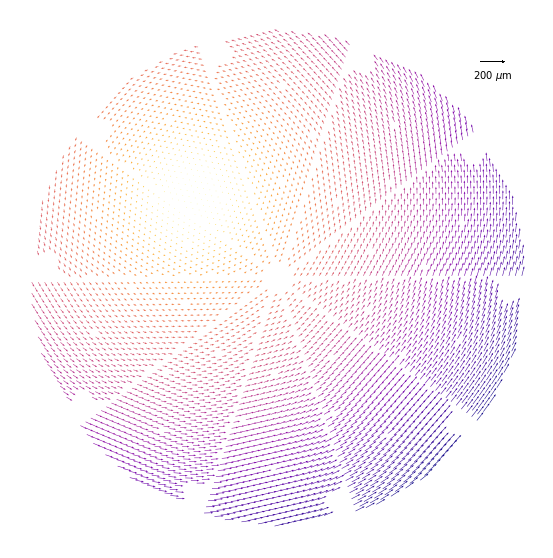

In [313]:
plot_align(20, 20, 30)

Plot the baseline petal alignment after the shutdown:

In [314]:
def get_alignment(name='focal_plane_metrology_200.json'):
    with open(name) as f:
        M = json.load(f)['elements']
    dx, dy, dalpha = np.zeros((3, 10))
    for P in M:
        C = P['constants']
        petal_loc = PETAL_ID_MAP.index(C['petal_id'])
        nominal = (petal_loc - 3) * np.pi / 5
        dx[petal_loc] = 1e3 * C['petal_offset_x']
        dy[petal_loc] = 1e3 * C['petal_offset_y']
        dalpha[petal_loc] = 3600 * np.rad2deg(C['petal_rot_3'] - nominal)
    return dx, dy, dalpha
    
DX, DY, DALPHA = get_alignment()

Max arrow length = 135.7 um


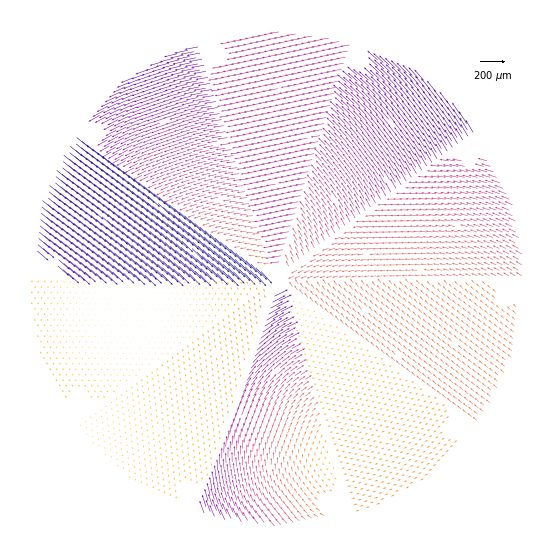

In [315]:
plot_align(DX, DY, DALPHA)

## Petal Local Hole Locations

Read the design hole locations from the "PATROL DISK / FIDUCIAL POSITIONS (ON FOCAL SURFACE Z1)" columns of the "PositionerAndFiducialLocations" tab of the [DESI-0530](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=530) spreadsheet. These are in the PTL coordinate system, i.e. mm relative to the petal origin with +x along one edge of the petal:

In [195]:
PETAL_DESIGN = pd.read_csv('DESI-0530-v18-coords.csv')

Remove non-positioners (fiducials, ETC):

In [196]:
PETAL_DESIGN = PETAL_DESIGN[PETAL_DESIGN.DEVICE_TYPE == 'POS']
print(f'Found design locations for {len(PETAL_DESIGN)} positioner holes per petal')

Found design locations for 500 positioner holes per petal


Expand to the full focal plane by copying the single petal design 10 times:

In [231]:
def expand_design():
    petals = []
    for PETAL_LOC in range(10):
        PETAL = PETAL_DESIGN.copy()
        PETAL['PETAL_LOC'] = PETAL_LOC
        petals.append(PETAL)
    DESIGN = pd.concat(petals)
    DESIGN['LOC'] = 1000 * DESIGN.PETAL_LOC + DESIGN.DEVICE_LOC
    DESIGN.sort_values(by='LOC', inplace=True)
    return DESIGN
        
DESIGN = expand_design()

Read the measured hole locations from the Unified Metrology CSV file of [DESI-5421](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=5421):

In [217]:
UMT = pd.read_csv('umt.csv')

Remove test-stand petals and non-positioners (fiducials, ETC):

In [232]:
UMT = UMT[(UMT.DEVICE_TYPE=='POS') & np.isin(UMT.PETAL_ID, PETAL_ID_MAP)]
UMT['LOC'] = 1000 * UMT.PETAL_LOC + UMT.DEVICE_LOC
UMT.sort_values(by='LOC', inplace=True)
print(f'Found metrology for {len(UMT)} positioner holes in 10 petals')

Found metrology for 5000 positioner holes in 10 petals


Compare the design and measured positions in each petal:

Max arrow length = 198.6 um


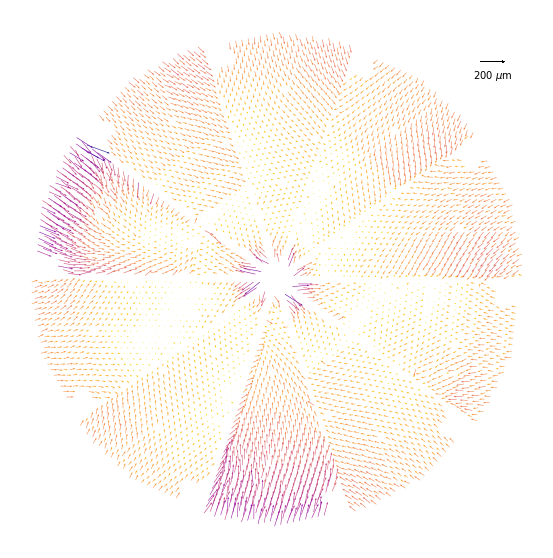

In [316]:
plot_dxy(DESIGN.PETAL_LOC, DESIGN.X_PTL, DESIGN.Y_PTL, UMT.X_PTL, UMT.Y_PTL)

## FVC Lens Distortion

In [376]:
FVC = FVC2FP.read('single-lens-fvc2fp.json')

In [342]:
FVC.scale, FVC.rotation, FVC.offset_x, FVC.offset_y

(1.0680063669627482,
 0.005236305042212609,
 0.0023968810093602457,
 -0.014241784900532663)

In [377]:
FVC.zbpolids

array([ 2,  5,  6,  9, 20, 28, 29, 30])

In [378]:
FVC.zbcoeffs

array([-2.73722832e-02,  4.10305444e-05, -5.18734869e-06,  6.92361431e-03,
        5.89448181e-05, -3.29357644e-06,  1.56545196e-05,  4.96997515e-06])

Max arrow length = 67.1 um


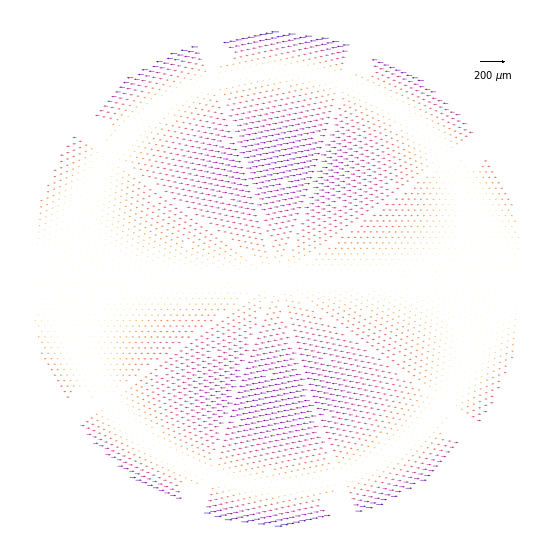

In [420]:
def plot_fvc_distortion(polids, coefs, mode='reverse', **kwargs):

    dx, dy, dalpha = np.zeros((3, 10))
    petal_loc = DESIGN.PETAL_LOC.to_numpy().astype(int)
    xptl, yptl = DESIGN.X_PTL, DESIGN.Y_PTL
    xfp, yfp = ptl2fp(petal_loc, xptl, yptl, dx, dy, dalpha)
    
    FVC = FVC2FP()
    xr, yr = FVC._reduce_xyfp(xfp, yfp)
    
    if mode == 'reverse':
        dxr = dyr = 0.
        for i in range(20):
            dxr2, dyr2 = getZhaoBurgeXY(polids, coefs, xr - dxr, yr - dyr)
            dmax = max(np.max(np.abs(dxr2 - dxr)), np.max(np.abs(dyr2 - dyr)))
            dxr, dry = dxr2, dyr2
            if dmax < 1e-12:
                break
        #print(i, dmax)
        xfp2, yfp2 = FVC._expand_xyfp(xr - dxr, yr - dyr)
    else:
        dxr, dyr = getZhaoBurgeXY(polids, coefs, xr, yr)
        xfp2, yfp2 = FVC._expand_xyfp(xr + dxr, yr + dyr)
    
    xptl2, yptl2 = fp2ptl(petal_loc, xfp2, yfp2, dx, dy, dalpha)
    plot_dxy(petal_loc, xptl, yptl, xptl2, yptl2, **kwargs)

#plot_fvc_distortion([2], [1e-4])
#plot_fvc_distortion([5], [1e-4])
#plot_fvc_distortion([6], [1e-4])
#plot_fvc_distortion([9], [1e-4])
#plot_fvc_distortion([20], [1e-4])
#plot_fvc_distortion([28], [1e-4])
#plot_fvc_distortion([29], [1e-4])
plot_fvc_distortion([30], [1e-4])

## Full FVC to PTL transformation

In [422]:
class Transformer(object):
    
    def __init__(self, petal_loc, device_loc, xfvc, yfvc):
        
        # Save the "reduced" FVC coordinates, scaled to [-1,-1] in both coords.
        self.FVC = FVC2FP()
        self.xfvc_reduced, self.yfvc_reduced = self.FVC._reduce_xyfvc(xfvc, yfvc)

        # Lookup the measured hole locations in PTL coords.
        self.petal_loc = petal_loc
        location = 1000 * petal_loc + device_loc
        UMT = pd.read_csv('umt.csv')
        idx = np.searchsorted(1000 * UMT.PETAL_LOC + UMT.DEVICE_LOC, location)
        assert np.all(UMT.LOCATION[idx] == location)
        self.xptl = UMT.X_PTL[idx]
        self.yptl = UMT.Y_PTL[idx]
        
        # Initialize the ZB distortion model.
        self.polids = [2, 5, 6, 9, 20, 28, 29, 30]

    def fvc2ptl(self, params):
        # Map from reduced FVC pixels to reduced FP coords.
        scale, rotation, offset_x, offset_y = params[:4]
        zbcoefs = params[4:12] # O(1e-4)
        dx = params[12:22] # microns
        dy = params[22:32] # microns
        dalpha = params[32:42] # arcsecs
        xfp_reduced, yfp_reduced = transform(scale, rotation, offset_x, offset_y, self.polids, zbcoefs)
        # Expand to full FP coords.
        xfp, yfp = self.FVC._expand_xyfp(xfp_reduced, yfp_reduced)
        # Undo petal alignments.
        return fp2ptl(self.petal_loc, xfp, yfp, dx, dy, dalpha)

    def nll(self, params):
        """Calculate a chi-square negative-log-likelihood suitable for minimization.
        """
        xptl, yptl = self.fvc2ptl(params)
        dx = xptl - self.xptl
        dy = yptl - self.yptl
        return np.hypot(dx, dy).sum()